In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

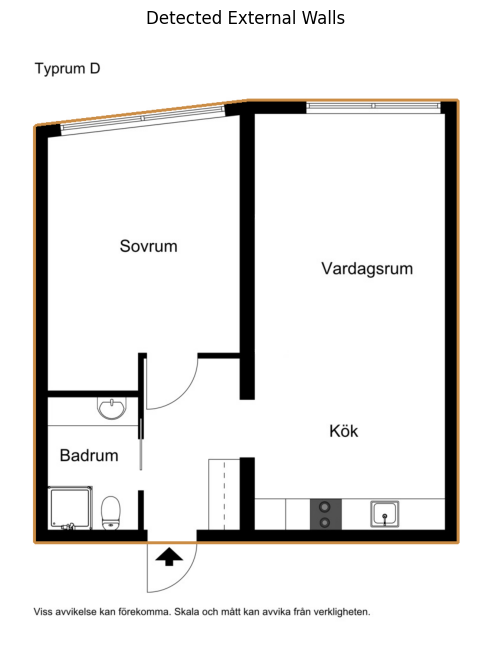

In [ ]:
def preprocess_image(image_path):
    # Load the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(image, (5, 5), 0)

    # Apply adaptive threshold to enhance edges
    thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 11, 2)

    # Remove small objects (text, labels) using morphological opening
    kernel = np.ones((3, 3), np.uint8)
    opened = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

    # Apply morphological closing to fill small gaps in walls
    kernel_large = np.ones((7, 7), np.uint8)  # Larger kernel for walls
    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel_large, iterations=3)

    # Dilate to reinforce thick areas (external walls) and remove thin ones (doors, text)
    dilated = cv2.dilate(closed, kernel_large, iterations=2)
    eroded = cv2.erode(dilated, kernel_large, iterations=2)

    # Detect edges using Canny
    edges = cv2.Canny(eroded, 50, 200)

    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter contours based on area to remove small objects (text, doors)
    min_contour_area = 5000  # Minimum area to be considered as an external wall
    filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_contour_area]

    # Merge filtered contours to get a single external shape
    if filtered_contours:
        merged_contour = np.vstack(filtered_contours)
        hull = cv2.convexHull(merged_contour)
    else:
        hull = np.array([])  # No valid external walls detected

    # Convert the image to color to draw on it
    image_with_contours = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    if hull.size > 0:
        cv2.drawContours(image_with_contours, [hull], -1, (68, 140, 203), 3)

    # Display the detected contour
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))
    plt.title("Detected External Walls")
    plt.axis("off")
    plt.show()

    return hull, image

# Example usage for contours
image_path = "1619982ritning.jpg"
contour, processed_image = preprocess_image(image_path)


In [ ]:
def detect_corners(contour, image):
    if contour.size == 0:
        print("No valid external wall contour detected.")
        return []

    # Approximate the contour to reduce the number of points
    epsilon = 0.005 * cv2.arcLength(contour, True)  # Higher precision for better corners
    approx = cv2.approxPolyDP(contour, epsilon, True)

    # Extract corner coordinates
    corner_points = [tuple(pt[0]) for pt in approx]

    # Analyze angles to keep sharp corners
    def angle_between(p1, p2, p3):
        a = np.array(p1)
        b = np.array(p2)
        c = np.array(p3)
        ab = a - b
        cb = c - b
        cosine_angle = np.dot(ab, cb) / (np.linalg.norm(ab) * np.linalg.norm(cb))
        angle = np.degrees(np.arccos(np.clip(cosine_angle, -1.0, 1.0)))
        return angle

    refined_corners = []
    for i in range(len(corner_points)):
        prev_point = corner_points[i - 1]
        curr_point = corner_points[i]
        next_point = corner_points[(i + 1) % len(corner_points)]
        angle = angle_between(prev_point, curr_point, next_point)

        # Keep corners with angles that indicate actual structural corners
        if angle < 180 and angle > 10:  # Ignore very slight bends
            refined_corners.append(curr_point)


    return refined_corners

# Example usage for corners
corners = detect_corners(contour, processed_image)
print("Detected corners:", corners)


Detected corners: [(758, 115), (759, 866), (42, 866), (41, 160), (405, 115)]


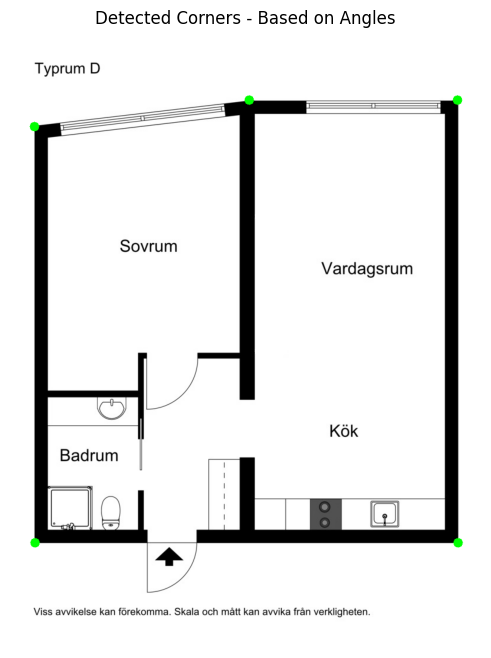

In [ ]:
# Convert the image to color to draw on it
image_with_corners = cv2.cvtColor(processed_image, cv2.COLOR_GRAY2BGR)
# Draw detected corners
for point in corners:
    cv2.circle(image_with_corners, point, 8, (0, 255, 0), -1)

# Display the result
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(image_with_corners, cv2.COLOR_BGR2RGB))
plt.title("Detected Corners - Based on Angles")
plt.axis("off")
plt.show()

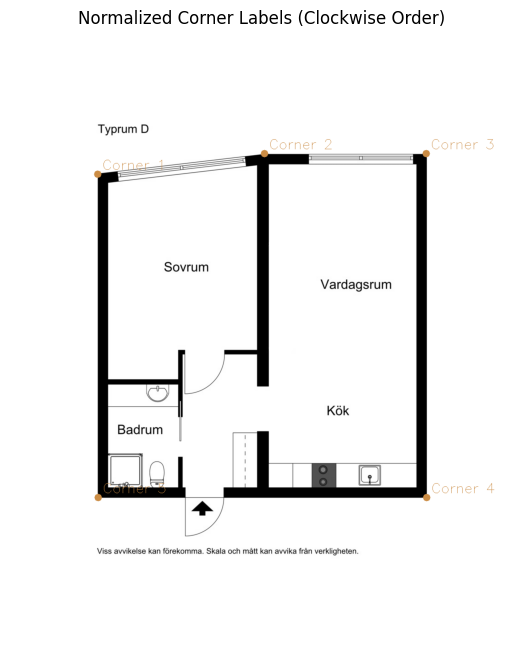

Normalized Corner Coordinates (Clockwise Order):
Corner 1: (0, 0)
Corner 2: (364, -45)
Corner 3: (717, -45)
Corner 4: (718, 706)
Corner 5: (1, 706)


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def normalize_corner_coordinates(corners, image):
    if not corners:
        print("No corners detected.")
        return []

    # Find the most left corner first, and if multiple exist, pick the highest
    origin = min(corners, key=lambda p: (p[0], p[1]))  # First, sort by x (left), then by y (top)

    # Sort remaining corners in clockwise order around the origin
    def clockwise_angle(point):
        dx, dy = point[0] - origin[0], point[1] - origin[1]
        return np.arctan2(dy, dx)

    sorted_corners = [origin] + sorted([p for p in corners if p != origin], key=clockwise_angle)

    # Normalize all corners relative to the origin
    normalized_corners = [(x - origin[0], y - origin[1]) for x, y in sorted_corners]

    # Add margin to the image to ensure text visibility
    margin = 150  # Adjust margin size as needed
    image_with_margin = cv2.copyMakeBorder(image, margin, margin, margin, margin, cv2.BORDER_CONSTANT, value=(255, 255, 255))

    # Convert the image to color to draw on it
    image_with_coords = cv2.cvtColor(image_with_margin, cv2.COLOR_GRAY2BGR)

    # Draw and label each corner
    for i, (x, y) in enumerate(sorted_corners):
        x_offset, y_offset = x + margin, y + margin  # Adjust for margin
        cv2.circle(image_with_coords, (x_offset, y_offset), 8, (68, 140, 203), -1)
        cv2.putText(image_with_coords, f"Corner {i+1}", (x_offset + 10, y_offset - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (68, 140, 203), 1)  # Green text without coordinates

    # Display the result
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(image_with_coords, cv2.COLOR_BGR2RGB))
    plt.title("Normalized Corner Labels (Clockwise Order)")
    plt.axis("off")
    plt.show()

    # Print the normalized coordinates
    print("Normalized Corner Coordinates (Clockwise Order):")
    for i, (nx, ny) in enumerate(normalized_corners):
        print(f"Corner {i+1}: ({nx}, {ny})")

    return normalized_corners

# Example usage (replace with actual detected corners from previous step)
corners = detect_corners(contour, processed_image)  # Assuming corners were detected earlier
normalized_corners = normalize_corner_coordinates(corners, processed_image)


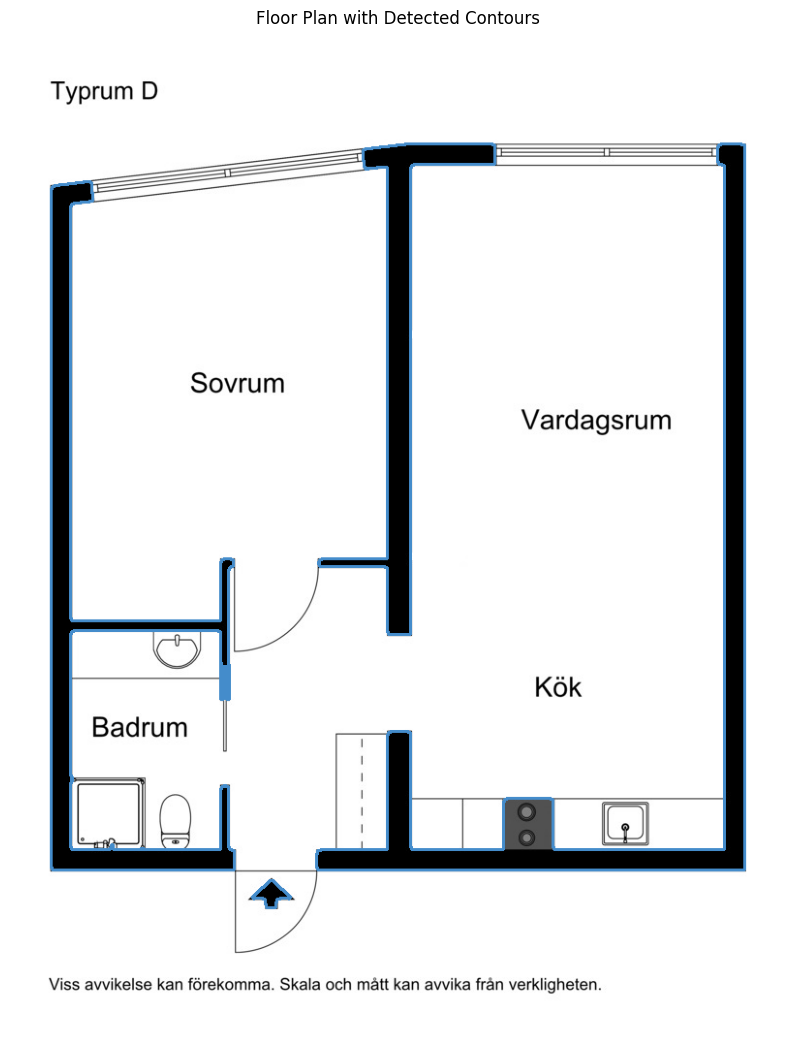

In [ ]:
# Load the original image
img_color = cv2.imread(image_path)
if img_color is None:
    raise IOError("Image not found! Check the path.")

# Convert to grayscale and apply binary thresholding followed by dilation
img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
_, binary = cv2.threshold(img_gray, 128, 255, cv2.THRESH_BINARY)
kernel = np.ones((3, 3), np.uint8)
dilated = cv2.dilate(binary, kernel, iterations=1)

# Apply GaussianBlur to reduce noise and improve edge detection on the dilated image
blurred = cv2.GaussianBlur(dilated, (5, 5), 0)

# Use Canny edge detector to find edges in the blurred image
edges = cv2.Canny(blurred, 600, 150, apertureSize=3)

# Find contours from the edged image
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on the color version of the original image
img_with_contours = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)  # Use original color image to show contours
cv2.drawContours(img_with_contours, contours, -1, (68, 140, 203), 2)  # Draw contours with blue lines

# Display the results
plt.figure(figsize=(10, 15))
plt.imshow(img_with_contours)
plt.title('Floor Plan with Detected Contours')
plt.axis('off')
plt.show()